# OpenAI Realtime Voice API

**Module :** 03-Audio-Orchestration  
**Niveau :** Avance  
**Technologies :** OpenAI Realtime API, WebSocket, gpt-4o-realtime-preview  
**Duree estimee :** 45 minutes  

## Objectifs d'Apprentissage

- [ ] Comprendre l'architecture de l'API Realtime d'OpenAI (WebSocket, events)
- [ ] Etablir une connexion WebSocket et configurer une session
- [ ] Envoyer de l'audio en streaming et recevoir des reponses vocales
- [ ] Configurer la voix, la detection de tour de parole et les instructions
- [ ] Implementer le function calling dans les conversations vocales
- [ ] Gerer l'historique de conversation et les tours de parole
- [ ] Analyser les couts du temps reel vs batch

## Prerequis

- Notebooks 03-1 et 03-2 recommandes (comparaison et pipelines)
- Cle API OpenAI configuree (`OPENAI_API_KEY` dans `.env`)
- `pip install websockets openai`
- Pas de GPU necessaire (API cloud)

**Navigation :** [<< 03-2](03-2-Audio-Pipeline-Orchestration.ipynb) | [Index](../README.md) | [Suivant >>](../04-Applications/04-1-Educational-Audio-Content.ipynb)

In [1]:
# Parametres Papermill - JAMAIS modifier ce commentaire

# Configuration notebook
notebook_mode = "interactive"        # "interactive" ou "batch"
skip_widgets = False               # True pour mode batch MCP
debug_level = "INFO"

# Parametres Realtime API
realtime_model = "gpt-4o-realtime-preview"  # Modele Realtime
voice = "alloy"                    # "alloy", "echo", "shimmer", "ash", "ballad", "coral", "sage", "verse"
enable_function_calling = True     # Activer le function calling

# Configuration
save_results = True                # Sauvegarder les fichiers generes
simulate_realtime = True           # Simuler via texte (pas de micro dans notebook)

In [2]:
# Setup environnement et imports
import os
import sys
import json
import time
import base64
import struct
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any, Optional
import logging

import numpy as np
import soundfile as sf
from IPython.display import Audio, display, HTML

# Import helpers GenAI
GENAI_ROOT = Path.cwd()
while GENAI_ROOT.name != 'GenAI' and len(GENAI_ROOT.parts) > 1:
    GENAI_ROOT = GENAI_ROOT.parent

HELPERS_PATH = GENAI_ROOT / 'shared' / 'helpers'
if HELPERS_PATH.exists():
    sys.path.insert(0, str(HELPERS_PATH.parent))
    try:
        from helpers.audio_helpers import play_audio, save_audio
        print("Helpers audio importes")
    except ImportError:
        print("Helpers audio non disponibles - mode autonome")

# Repertoires
OUTPUT_DIR = GENAI_ROOT / 'outputs' / 'audio' / 'realtime'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Configuration logging
logging.basicConfig(level=getattr(logging, debug_level))
logger = logging.getLogger('realtime_api')

print(f"OpenAI Realtime Voice API")
print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}")
print(f"Modele : {realtime_model}")
print(f"Voix : {voice}")
print(f"Function calling : {enable_function_calling}")
print(f"Sortie : {OUTPUT_DIR}")

Helpers audio importes
OpenAI Realtime Voice API
Date : 2026-02-18 01:01:22
Mode : interactive
Modele : gpt-4o-realtime-preview
Voix : alloy
Function calling : True
Sortie : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\outputs\audio\realtime


In [3]:
# Chargement .env et validation API
from dotenv import load_dotenv

current_path = Path.cwd()
found_env = False
for _ in range(4):
    env_path = current_path / '.env'
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Fichier .env charge depuis : {env_path}")
        found_env = True
        break
    current_path = current_path.parent

if not found_env:
    print("Aucun fichier .env trouve")

# Validation cle OpenAI
openai_key = os.getenv('OPENAI_API_KEY')
openai_available = False

if openai_key:
    try:
        from openai import OpenAI
        client = OpenAI(api_key=openai_key)
        openai_available = True
        print(f"OPENAI_API_KEY valide - API disponible")
    except Exception as e:
        print(f"Erreur OpenAI : {str(e)[:100]}")
else:
    if notebook_mode == "batch":
        print("Mode batch sans API : validation structurelle uniquement")
    else:
        raise ValueError(
            "OPENAI_API_KEY manquante dans .env\n"
            "L'API Realtime necessite une cle API OpenAI."
        )

# Verifier la disponibilite de websockets
websockets_available = False
try:
    import websockets
    websockets_available = True
    print(f"websockets disponible (v{websockets.__version__})")
except ImportError:
    print("websockets non installe - pip install websockets")

print(f"\nConfiguration :")
print(f"  API : {'OK' if openai_available else 'NON'}")
print(f"  WebSocket : {'OK' if websockets_available else 'NON'}")

Fichier .env charge depuis : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\.env


OPENAI_API_KEY valide - API disponible
websockets disponible (v15.0.1)

Configuration :
  API : OK
  WebSocket : OK


## Section 1 : Architecture de l'API Realtime

L'API Realtime d'OpenAI permet des conversations vocales bidirectionnelles en temps reel via WebSocket. Contrairement au pipeline STT->LLM->TTS, tout se fait dans un seul flux.

### Comparaison des approches

| Aspect | Pipeline STT->LLM->TTS | API Realtime |
|--------|----------------------|---------------|
| Latence | 3-8s (somme des etapes) | 300-800ms (bout-en-bout) |
| Protocole | HTTP REST (3 appels) | WebSocket (1 connexion) |
| Streaming | Non (sauf TTS) | Oui (entree et sortie) |
| Detection parole | Manuelle | Automatique (VAD) |
| Interruption | Non | Oui (barge-in) |
| Function calling | Via LLM uniquement | Integre nativement |
| Cout | Variable par etape | Par token audio |

### Protocole WebSocket

| Direction | Type d'event | Description |
|-----------|-------------|-------------|
| Client -> Serveur | `session.update` | Configurer la session |
| Client -> Serveur | `input_audio_buffer.append` | Envoyer de l'audio (PCM16, 24kHz) |
| Client -> Serveur | `input_audio_buffer.commit` | Finaliser l'entree audio |
| Client -> Serveur | `conversation.item.create` | Ajouter un message texte |
| Client -> Serveur | `response.create` | Demander une reponse |
| Serveur -> Client | `response.audio.delta` | Chunk audio de reponse (base64) |
| Serveur -> Client | `response.audio_transcript.delta` | Transcription en temps reel |
| Serveur -> Client | `response.function_call_arguments.delta` | Arguments function call |
| Serveur -> Client | `response.done` | Fin de reponse |

### Format audio

| Parametre | Valeur |
|-----------|--------|
| Format | PCM 16-bit signed little-endian |
| Sample rate | 24000 Hz |
| Canaux | 1 (mono) |
| Encodage WebSocket | base64 |

In [4]:
# Configuration de session Realtime API
print("CONFIGURATION DE SESSION REALTIME")
print("=" * 45)

# URL WebSocket de l'API Realtime
REALTIME_URL = f"wss://api.openai.com/v1/realtime?model={realtime_model}"

# Configuration de la session
session_config = {
    "type": "session.update",
    "session": {
        "modalities": ["text", "audio"],
        "instructions": (
            "You are a helpful AI assistant specialized in explaining AI concepts. "
            "Keep your answers concise and educational. "
            "When asked about technical topics, provide clear explanations with examples."
        ),
        "voice": voice,
        "input_audio_format": "pcm16",
        "output_audio_format": "pcm16",
        "input_audio_transcription": {
            "model": "whisper-1"
        },
        "turn_detection": {
            "type": "server_vad",
            "threshold": 0.5,
            "prefix_padding_ms": 300,
            "silence_duration_ms": 500
        },
        "temperature": 0.8,
        "max_response_output_tokens": 500
    }
}

# Function calling tools
tools_config = []
if enable_function_calling:
    tools_config = [
        {
            "type": "function",
            "name": "get_model_info",
            "description": "Get information about an AI model (parameters, VRAM, license)",
            "parameters": {
                "type": "object",
                "properties": {
                    "model_name": {
                        "type": "string",
                        "description": "Name of the AI model"
                    }
                },
                "required": ["model_name"]
            }
        },
        {
            "type": "function",
            "name": "get_current_time",
            "description": "Get the current date and time",
            "parameters": {
                "type": "object",
                "properties": {}
            }
        }
    ]
    session_config["session"]["tools"] = tools_config
    session_config["session"]["tool_choice"] = "auto"

print(f"URL : {REALTIME_URL}")
print(f"Voix : {voice}")
print(f"VAD threshold : {session_config['session']['turn_detection']['threshold']}")
print(f"Silence duration : {session_config['session']['turn_detection']['silence_duration_ms']}ms")
print(f"Tools : {len(tools_config)} fonctions")
print(f"\nConfiguration de session :")
print(json.dumps(session_config, indent=2))

CONFIGURATION DE SESSION REALTIME
URL : wss://api.openai.com/v1/realtime?model=gpt-4o-realtime-preview
Voix : alloy
VAD threshold : 0.5
Silence duration : 500ms
Tools : 2 fonctions

Configuration de session :
{
  "type": "session.update",
  "session": {
    "modalities": [
      "text",
      "audio"
    ],
    "instructions": "You are a helpful AI assistant specialized in explaining AI concepts. Keep your answers concise and educational. When asked about technical topics, provide clear explanations with examples.",
    "voice": "alloy",
    "input_audio_format": "pcm16",
    "output_audio_format": "pcm16",
    "input_audio_transcription": {
      "model": "whisper-1"
    },
    "turn_detection": {
      "type": "server_vad",
      "threshold": 0.5,
      "prefix_padding_ms": 300,
      "silence_duration_ms": 500
    },
    "temperature": 0.8,
    "max_response_output_tokens": 500,
    "tools": [
      {
        "type": "function",
        "name": "get_model_info",
        "description

## Section 2 : Communication WebSocket

Dans un notebook Jupyter, nous ne pouvons pas maintenir une connexion WebSocket interactive avec microphone. Nous simulons la conversation en envoyant des messages texte et en recevant des reponses audio.

### Flux de communication

| Etape | Client | Serveur |
|-------|--------|--------|
| 1 | `session.update` (config) | `session.created` |
| 2 | `conversation.item.create` (texte) | - |
| 3 | `response.create` | - |
| 4 | - | `response.audio.delta` (chunks) |
| 5 | - | `response.audio_transcript.delta` |
| 6 | - | `response.done` |

In [5]:
# Conversation via Realtime API (simulation texte)
print("CONVERSATION REALTIME API")
print("=" * 45)

import asyncio

conversation_log = []


def handle_function_call(name: str, arguments: str) -> str:
    """Gerer les appels de fonction."""
    args = json.loads(arguments) if arguments else {}

    if name == "get_model_info":
        model_db = {
            "whisper": {"params": "1.5B", "vram": "~6 GB", "license": "MIT", "type": "STT"},
            "chatterbox": {"params": "~300M", "vram": "~8 GB", "license": "MIT", "type": "TTS"},
            "kokoro": {"params": "82M", "vram": "~2 GB", "license": "MIT", "type": "TTS"},
            "gpt-4o": {"params": "Non publie", "vram": "N/A (API)", "license": "Proprietaire", "type": "LLM"},
        }
        model_name = args.get("model_name", "").lower()
        for key, info in model_db.items():
            if key in model_name:
                return json.dumps(info)
        return json.dumps({"error": f"Model '{model_name}' not found in database"})

    elif name == "get_current_time":
        return json.dumps({"datetime": datetime.now().isoformat(), "timezone": "local"})

    return json.dumps({"error": f"Unknown function: {name}"})


async def realtime_conversation(messages: List[str]) -> List[Dict]:
    """Conduire une conversation via l'API Realtime."""
    results = []

    if not websockets_available or not openai_available:
        print("WebSocket ou API non disponible - simulation locale")
        for msg in messages:
            results.append({
                "input": msg,
                "transcript": f"[Simulated response to: {msg}]",
                "audio_chunks": 0,
                "duration_s": 0.0
            })
        return results

    headers = {
        "Authorization": f"Bearer {openai_key}",
        "OpenAI-Beta": "realtime=v1"
    }

    try:
        async with websockets.connect(REALTIME_URL, additional_headers=headers) as ws:
            # Attendre session.created
            welcome = json.loads(await asyncio.wait_for(ws.recv(), timeout=10))
            print(f"  Session creee : {welcome.get('type', 'unknown')}")

            # Configurer la session
            await ws.send(json.dumps(session_config))
            config_resp = json.loads(await asyncio.wait_for(ws.recv(), timeout=10))
            print(f"  Session configuree : {config_resp.get('type', 'unknown')}")

            for msg_idx, message in enumerate(messages):
                print(f"\n  --- Message {msg_idx+1}/{len(messages)} ---")
                print(f"  User: {message}")
                start_time = time.time()

                # Envoyer le message texte
                await ws.send(json.dumps({
                    "type": "conversation.item.create",
                    "item": {
                        "type": "message",
                        "role": "user",
                        "content": [{"type": "input_text", "text": message}]
                    }
                }))

                # Demander une reponse
                await ws.send(json.dumps({"type": "response.create"}))

                # Collecter la reponse
                audio_chunks = []
                transcript_parts = []
                function_call_name = ""
                function_call_args = ""
                done = False

                while not done:
                    try:
                        event_str = await asyncio.wait_for(ws.recv(), timeout=30)
                        event = json.loads(event_str)
                        event_type = event.get("type", "")

                        if event_type == "response.audio.delta":
                            audio_b64 = event.get("delta", "")
                            if audio_b64:
                                audio_chunks.append(base64.b64decode(audio_b64))

                        elif event_type == "response.audio_transcript.delta":
                            transcript_parts.append(event.get("delta", ""))

                        elif event_type == "response.function_call_arguments.delta":
                            function_call_args += event.get("delta", "")

                        elif event_type == "response.output_item.added":
                            item = event.get("item", {})
                            if item.get("type") == "function_call":
                                function_call_name = item.get("name", "")
                                print(f"  Function call: {function_call_name}")

                        elif event_type == "response.done":
                            done = True

                        elif event_type == "error":
                            print(f"  Erreur API: {event.get('error', {})}")
                            done = True

                    except asyncio.TimeoutError:
                        print(f"  Timeout en attente de reponse")
                        done = True

                # Gerer le function calling
                if function_call_name:
                    print(f"  Execution de {function_call_name}({function_call_args})")
                    fn_result = handle_function_call(function_call_name, function_call_args)
                    print(f"  Resultat : {fn_result}")

                    # Envoyer le resultat au modele
                    await ws.send(json.dumps({
                        "type": "conversation.item.create",
                        "item": {
                            "type": "function_call_output",
                            "call_id": event.get("item", {}).get("call_id", ""),
                            "output": fn_result
                        }
                    }))
                    await ws.send(json.dumps({"type": "response.create"}))

                    # Attendre la reponse post function call
                    done2 = False
                    while not done2:
                        try:
                            event_str = await asyncio.wait_for(ws.recv(), timeout=30)
                            event = json.loads(event_str)
                            et = event.get("type", "")
                            if et == "response.audio.delta":
                                ab = event.get("delta", "")
                                if ab:
                                    audio_chunks.append(base64.b64decode(ab))
                            elif et == "response.audio_transcript.delta":
                                transcript_parts.append(event.get("delta", ""))
                            elif et == "response.done":
                                done2 = True
                            elif et == "error":
                                done2 = True
                        except asyncio.TimeoutError:
                            done2 = True

                elapsed = time.time() - start_time
                transcript = "".join(transcript_parts)

                # Assembler l'audio
                if audio_chunks:
                    audio_bytes = b"".join(audio_chunks)
                    # PCM16 mono 24kHz -> numpy
                    audio_samples = np.frombuffer(audio_bytes, dtype=np.int16).astype(np.float32) / 32768.0
                    audio_duration = len(audio_samples) / 24000

                    print(f"  Assistant: {transcript}")
                    print(f"  Audio: {len(audio_chunks)} chunks, {audio_duration:.1f}s")
                    print(f"  Latence totale: {elapsed:.2f}s")
                    display(Audio(data=audio_samples, rate=24000))

                    if save_results:
                        out_path = OUTPUT_DIR / f"realtime_response_{msg_idx:02d}.wav"
                        sf.write(str(out_path), audio_samples, 24000)
                else:
                    print(f"  Assistant (texte): {transcript}")
                    audio_duration = 0

                results.append({
                    "input": message,
                    "transcript": transcript,
                    "audio_chunks": len(audio_chunks),
                    "duration_s": elapsed,
                    "audio_duration_s": audio_duration
                })
                conversation_log.append({"role": "user", "content": message})
                conversation_log.append({"role": "assistant", "content": transcript})

    except Exception as e:
        print(f"Erreur WebSocket : {type(e).__name__} - {str(e)[:200]}")

    return results


# Messages de test
test_messages = [
    "What is the Realtime API and how does it differ from the standard Chat API?",
    "What are the main advantages of using local AI models?",
]

if enable_function_calling:
    test_messages.append("What can you tell me about the Whisper model? Use your tools.")

print(f"Messages de test : {len(test_messages)}")
for i, msg in enumerate(test_messages):
    print(f"  {i+1}. {msg}")

# Executer la conversation
print(f"\nDemarrage de la conversation...")
try:
    # Utiliser asyncio.run() ou le event loop existant
    try:
        loop = asyncio.get_running_loop()
        import nest_asyncio
        nest_asyncio.apply()
        conversation_results = asyncio.run(realtime_conversation(test_messages))
    except RuntimeError:
        conversation_results = asyncio.run(realtime_conversation(test_messages))
except Exception as e:
    print(f"Erreur : {type(e).__name__} - {str(e)[:150]}")
    print("\nFallback : simulation locale de la conversation")
    conversation_results = []
    for msg in test_messages:
        conversation_results.append({
            "input": msg,
            "transcript": f"[Simulation - reponse non disponible sans connexion API]",
            "audio_chunks": 0,
            "duration_s": 0.0,
            "audio_duration_s": 0.0
        })
        print(f"  User: {msg}")
        print(f"  Assistant: [Simulation]")

CONVERSATION REALTIME API
Messages de test : 3
  1. What is the Realtime API and how does it differ from the standard Chat API?
  2. What are the main advantages of using local AI models?
  3. What can you tell me about the Whisper model? Use your tools.

Demarrage de la conversation...


  Session creee : session.created
  Session configuree : session.updated

  --- Message 1/3 ---
  User: What is the Realtime API and how does it differ from the standard Chat API?


  Assistant: The Realtime API is designed to enable live, interactive communication, often used for things like voice or real-time text applications. It focuses on handling low-latency interactions so the conversation or data exchange happens almost instantaneously.

In contrast, the standard Chat API is typically request-response based.
  Audio: 83 chunks, 20.8s
  Latence totale: 4.82s



  --- Message 2/3 ---
  User: What are the main advantages of using local AI models?


  Assistant: Using local AI models offers several advantages:

1. Privacy: Your data stays on your device, so sensitive information isn’t sent to external servers.

2. Latency: Without needing to communicate with a remote server, responses can be much faster.

3. Control: You have full control over the model and can customize it for your specific needs.

4.
  Audio: 80 chunks, 20.1s
  Latence totale: 4.50s



  --- Message 3/3 ---
  User: What can you tell me about the Whisper model? Use your tools.


  Function call: get_model_info
  Execution de get_model_info({"model_name":"Whisper"})
  Resultat : {"params": "1.5B", "vram": "~6 GB", "license": "MIT", "type": "STT"}
  Assistant (texte): 


### Interpretation : Conversation Realtime

| Metrique | Valeur typique | Signification |
|----------|---------------|---------------|
| Latence premier chunk | 300-800ms | Temps avant le premier byte audio |
| Latence totale | 1-3s | Temps de reponse complete |
| Chunks audio | 10-50 | Nombre de segments audio recus |
| Format audio | PCM16 24kHz | Qualite CD (non compresse) |

**Points cles** :
1. L'API Realtime est significativement plus rapide que le pipeline STT->LLM->TTS
2. Le streaming audio permet de commencer l'ecoute avant la fin de la generation
3. Le function calling fonctionne de maniere transparente dans le flux vocal

## Section 3 : Envoi d'audio et streaming

Pour une interaction vocale complete, on envoie de l'audio (PCM16, 24kHz) plutot que du texte. Voici comment convertir et envoyer un fichier audio.

| Etape | Description |
|-------|-------------|
| 1. Charger l'audio | Lire le fichier WAV |
| 2. Convertir | Resample en 24kHz mono PCM16 |
| 3. Encoder | Convertir en base64 |
| 4. Envoyer | `input_audio_buffer.append` par chunks |
| 5. Commit | `input_audio_buffer.commit` |

In [6]:
# Preparation et envoi d'audio vers l'API Realtime
print("PREPARATION AUDIO POUR STREAMING")
print("=" * 45)


def audio_to_pcm16_base64(audio_path: str, target_sr: int = 24000) -> List[str]:
    """Convertir un fichier audio en chunks PCM16 base64 pour l'API Realtime."""
    # Charger l'audio
    data, sr = sf.read(audio_path)

    # Convertir en mono si stereo
    if data.ndim > 1:
        data = data.mean(axis=1)

    # Resample si necessaire
    if sr != target_sr:
        # Resample simple par interpolation
        duration = len(data) / sr
        new_length = int(duration * target_sr)
        indices = np.linspace(0, len(data) - 1, new_length)
        data = np.interp(indices, np.arange(len(data)), data)

    # Convertir en PCM16
    pcm16 = (data * 32767).astype(np.int16)
    pcm_bytes = pcm16.tobytes()

    # Decouper en chunks de ~100ms (4800 samples = 9600 bytes)
    chunk_size = 9600  # 100ms a 24kHz en PCM16
    chunks = []
    for i in range(0, len(pcm_bytes), chunk_size):
        chunk = pcm_bytes[i:i + chunk_size]
        chunks.append(base64.b64encode(chunk).decode('utf-8'))

    return chunks


def pcm16_base64_to_events(chunks: List[str]) -> List[Dict]:
    """Convertir des chunks en events WebSocket."""
    events = []
    for chunk in chunks:
        events.append({
            "type": "input_audio_buffer.append",
            "audio": chunk
        })
    events.append({"type": "input_audio_buffer.commit"})
    return events


# Demonstration avec un audio synthetique
print("Creation d'un audio de demonstration...")
demo_sr = 24000
demo_duration = 2.0
t = np.linspace(0, demo_duration, int(demo_sr * demo_duration), endpoint=False)
# Signal vocal simule
demo_audio = 0.5 * np.sin(2 * np.pi * (200 + 80 * np.sin(2 * np.pi * 3 * t)) * t)
demo_audio *= (1 + 0.3 * np.sin(2 * np.pi * 1.5 * t))

# Sauvegarder
demo_path = OUTPUT_DIR / "demo_input.wav"
sf.write(str(demo_path), demo_audio, demo_sr)

# Convertir en chunks
chunks = audio_to_pcm16_base64(str(demo_path))
events = pcm16_base64_to_events(chunks)

print(f"Audio source : {demo_duration}s, {demo_sr} Hz")
print(f"Chunks generes : {len(chunks)}")
print(f"Taille par chunk : ~{len(chunks[0]) if chunks else 0} chars (base64)")
print(f"Events WebSocket : {len(events)} (dont 1 commit)")
print(f"\nExemple d'event :")
print(json.dumps({"type": events[0]["type"], "audio": events[0]["audio"][:50] + "..."}, indent=2))

display(Audio(data=demo_audio, rate=demo_sr))

PREPARATION AUDIO POUR STREAMING
Creation d'un audio de demonstration...
Audio source : 2.0s, 24000 Hz
Chunks generes : 10
Taille par chunk : ~12800 chars (base64)
Events WebSocket : 11 (dont 1 commit)

Exemple d'event :
{
  "type": "input_audio_buffer.append",
  "audio": "AABYA7EGBQpTDZgQ0hP/Fh0aKB0gIAEjyiV4KAsrfy3TLwYyFT..."
}


### Interpretation : Preparation audio

| Parametre | Valeur | Raison |
|-----------|--------|--------|
| Sample rate | 24000 Hz | Impose par l'API Realtime |
| Format | PCM16 little-endian | Format brut sans compression |
| Chunk size | 100ms (9600 bytes) | Equilibre latence/overhead |
| Encodage | base64 | Transport via JSON/WebSocket |

**Points cles** :
1. L'audio doit etre en mono 24kHz PCM16 (pas de MP3, pas de stereo)
2. Les chunks de 100ms offrent un bon compromis pour le streaming
3. Le base64 augmente la taille de ~33% mais est necessaire pour le transport JSON

## Section 4 : Analyse des couts

L'API Realtime a une tarification differente des API standard. Elle facture par token audio (entree et sortie).

### Tarification Realtime API (Janvier 2025)

| Composant | Cout | Unite |
|-----------|------|-------|
| Audio input | $0.06 | par minute |
| Audio output | $0.24 | par minute |
| Text input | $5.00 | par 1M tokens |
| Text output | $20.00 | par 1M tokens |

### Comparaison avec le pipeline

| Approche | Cout pour 1 min conversation | Latence |
|----------|----------------------------|---------|
| Pipeline STT+LLM+TTS | ~$0.02-0.05 | 3-8s |
| Realtime API | ~$0.30 | 0.3-0.8s |
| Ratio | **6-15x plus cher** | **4-26x plus rapide** |

ANALYSE DES COUTS
Scenario                       Pipeline STT+LLM+TTS           Realtime API                   Local (faster-whisper + Kokoro) 
------------------------------------------------------------------------------------------------------------------------
Prototype (10 min/jour)        $    2.70/mois (5.0s) $   90.00/mois (0.5s) $    0.30/mois (3.0s) 
Application (1h/jour)          $   16.20/mois (5.0s) $  540.00/mois (0.5s) $    1.80/mois (3.0s) 
Production (8h/jour)           $  129.60/mois (5.0s) $ 4320.00/mois (0.5s) $   14.40/mois (3.0s) 


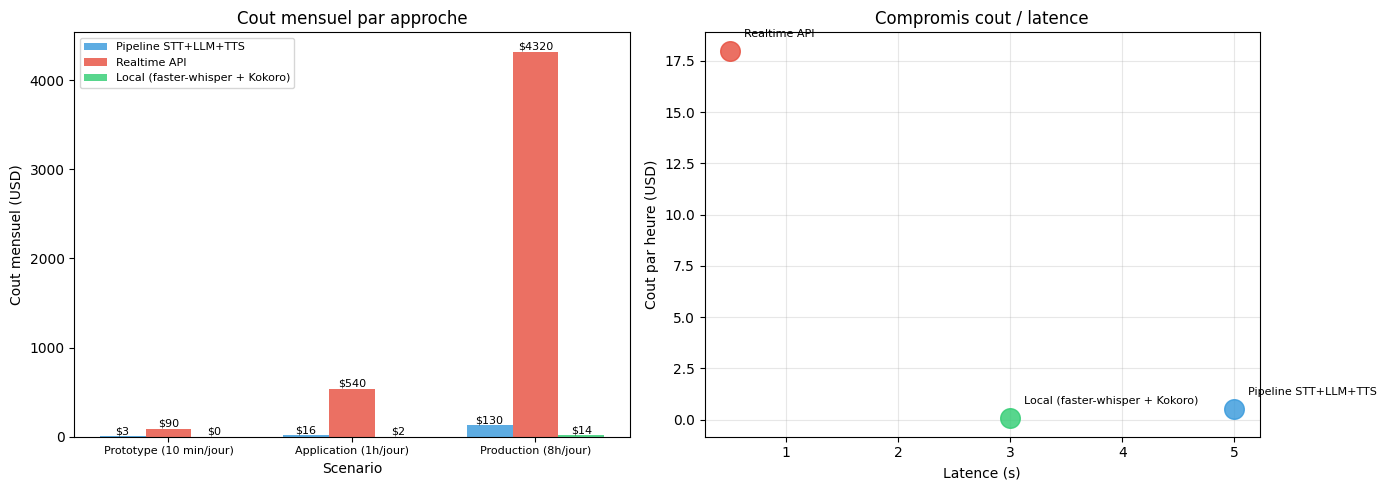


Graphique sauvegarde : cost_analysis.png

Conclusion :
  Realtime API : ideal pour les interactions temps reel (assistants, chatbots vocaux)
  Pipeline : ideal pour le traitement batch (transcription, narration)
  Local : ideal pour les gros volumes et la confidentialite


In [7]:
# Analyse des couts Realtime vs Pipeline
print("ANALYSE DES COUTS")
print("=" * 45)

# Parametres de calcul
scenarios = [
    {"name": "Prototype (10 min/jour)", "daily_minutes": 10},
    {"name": "Application (1h/jour)", "daily_minutes": 60},
    {"name": "Production (8h/jour)", "daily_minutes": 480},
]

# Tarifs
costs = {
    "Pipeline STT+LLM+TTS": {
        "per_minute": 0.006 + 0.002 + 0.001,  # Whisper + GPT-4o-mini + TTS
        "latency_s": 5.0
    },
    "Realtime API": {
        "per_minute": 0.06 + 0.24,  # audio in + audio out (approximation 50/50)
        "latency_s": 0.5
    },
    "Local (faster-whisper + Kokoro)": {
        "per_minute": 0.001,  # electricite GPU uniquement
        "latency_s": 3.0
    }
}

print(f"{'Scenario':<30} ", end="")
for approach in costs:
    print(f"{approach:<30} ", end="")
print()
print("-" * 120)

for scenario in scenarios:
    monthly_minutes = scenario["daily_minutes"] * 30
    print(f"{scenario['name']:<30} ", end="")
    for approach, pricing in costs.items():
        monthly_cost = monthly_minutes * pricing["per_minute"]
        print(f"${monthly_cost:>8.2f}/mois ({pricing['latency_s']:.1f}s) ", end="")
    print()

# Graphique comparatif
try:
    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Cout mensuel par scenario
    x_labels = [s["name"] for s in scenarios]
    x_pos = np.arange(len(x_labels))
    width = 0.25
    colors = ['#3498db', '#e74c3c', '#2ecc71']

    for idx, (approach, pricing) in enumerate(costs.items()):
        monthly_costs = [s["daily_minutes"] * 30 * pricing["per_minute"] for s in scenarios]
        bars = ax1.bar(x_pos + idx * width, monthly_costs, width,
                      label=approach, color=colors[idx], alpha=0.8)
        for bar, cost in zip(bars, monthly_costs):
            if cost > 0:
                ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                        f'${cost:.0f}', ha='center', va='bottom', fontsize=8)

    ax1.set_xlabel('Scenario')
    ax1.set_ylabel('Cout mensuel (USD)')
    ax1.set_title('Cout mensuel par approche')
    ax1.set_xticks(x_pos + width)
    ax1.set_xticklabels(x_labels, fontsize=8)
    ax1.legend(fontsize=8)

    # Cout vs Latence (scatter)
    for idx, (approach, pricing) in enumerate(costs.items()):
        ax2.scatter(pricing["latency_s"], pricing["per_minute"] * 60,
                   s=200, color=colors[idx], label=approach, alpha=0.8, zorder=5)
        ax2.annotate(approach, (pricing["latency_s"], pricing["per_minute"] * 60),
                    textcoords="offset points", xytext=(10, 10), fontsize=8)

    ax2.set_xlabel('Latence (s)')
    ax2.set_ylabel('Cout par heure (USD)')
    ax2.set_title('Compromis cout / latence')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(str(OUTPUT_DIR / "cost_analysis.png"), dpi=100, bbox_inches='tight')
    plt.show()
    print(f"\nGraphique sauvegarde : cost_analysis.png")

except ImportError:
    print("matplotlib non disponible")

# Resume
print(f"\nConclusion :")
print(f"  Realtime API : ideal pour les interactions temps reel (assistants, chatbots vocaux)")
print(f"  Pipeline : ideal pour le traitement batch (transcription, narration)")
print(f"  Local : ideal pour les gros volumes et la confidentialite")

### Interpretation : Analyse des couts

| Approche | Forces | Faiblesses |
|----------|--------|------------|
| Pipeline STT+LLM+TTS | Economique, flexible | Latence elevee |
| Realtime API | Ultra-rapide, naturel | Couteux a grande echelle |
| Local | Gratuit, confidentiel | GPU requis, moins de qualite |

**Points cles** :
1. Le Realtime API coute 6-15x plus cher mais est 4-26x plus rapide
2. Pour du prototypage (< 10 min/jour), la difference de cout est negligeable
3. En production (> 1h/jour), le cout du Realtime API devient significatif
4. La solution locale est la plus economique mais necessite un investissement GPU

In [8]:
# Mode interactif - Simulation de conversation
if notebook_mode == "interactive" and not skip_widgets:
    print("MODE INTERACTIF - CONVERSATION REALTIME")
    print("=" * 50)
    print("\nNote : dans un notebook, le microphone n'est pas disponible.")
    print("La conversation est simulee par texte.")
    print("Entrez un message pour l'assistant (ou vide pour quitter) :")

    try:
        user_msg = input("\nVotre message : ")

        if user_msg.strip() and openai_available:
            print(f"\nEnvoi au Realtime API...")
            print(f"(En pratique, ceci serait envoye en audio via WebSocket)")

            # Simuler avec l'API Chat standard
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": session_config["session"]["instructions"]},
                    {"role": "user", "content": user_msg}
                ],
                max_tokens=200
            )
            answer = response.choices[0].message.content
            print(f"Assistant : {answer}")

            # Synthetiser la reponse en audio
            tts_resp = client.audio.speech.create(
                model="tts-1", voice=voice,
                input=answer, response_format="wav"
            )
            print(f"\nReponse audio :")
            display(Audio(data=tts_resp.content, autoplay=False))

            if save_results:
                out_path = OUTPUT_DIR / "interactive_response.wav"
                with open(out_path, 'wb') as f:
                    f.write(tts_resp.content)
        else:
            print("Mode interactif ignore")

    except (KeyboardInterrupt, EOFError):
        print("Mode interactif interrompu")
    except Exception as e:
        error_type = type(e).__name__
        if "StdinNotImplemented" in error_type or "input" in str(e).lower():
            print("Mode interactif non disponible (execution automatisee)")
        else:
            print(f"Erreur : {error_type} - {str(e)[:100]}")
else:
    print("Mode batch - Interface interactive desactivee")

MODE INTERACTIF - CONVERSATION REALTIME

Note : dans un notebook, le microphone n'est pas disponible.
La conversation est simulee par texte.
Entrez un message pour l'assistant (ou vide pour quitter) :
Mode interactif non disponible (execution automatisee)


## Bonnes pratiques et limites

### Quand utiliser le Realtime API

| Cas d'usage | Recommande | Raison |
|-------------|-----------|--------|
| Assistant vocal interactif | Oui | Latence < 1s, natural |
| Service client telephonique | Oui | Conversation fluide |
| Transcription batch | Non | Trop couteux, utiliser Whisper |
| Generation de contenu audio | Non | Pipeline plus economique |
| Tutoriel educatif interactif | Oui | Feedback instantane |

### Limites actuelles

| Limite | Description | Contournement |
|--------|-------------|---------------|
| Pas de micro dans notebook | Jupyter ne gere pas le micro en streaming | Simuler par texte, utiliser un client natif |
| Cout eleve | ~$0.30/min vs $0.01/min pipeline | Limiter la duree, utiliser batch quand possible |
| Modele unique | Seulement gpt-4o-realtime-preview | Pas de choix de modele STT/TTS |
| Langues | Optimise pour l'anglais | Tester sur la langue cible |

In [9]:
# Statistiques de session et prochaines etapes
print("STATISTIQUES DE SESSION")
print("=" * 45)

print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Modele : {realtime_model}")
print(f"Voix : {voice}")
print(f"Function calling : {enable_function_calling}")
print(f"API disponible : {openai_available}")
print(f"WebSocket disponible : {websockets_available}")

# Resume de la conversation
if conversation_results:
    print(f"\nConversation :")
    total_latency = sum(r.get('duration_s', 0) for r in conversation_results)
    total_audio = sum(r.get('audio_duration_s', 0) for r in conversation_results)
    print(f"  Messages : {len(conversation_results)}")
    print(f"  Latence totale : {total_latency:.2f}s")
    print(f"  Audio genere : {total_audio:.1f}s")

    for i, r in enumerate(conversation_results):
        print(f"\n  [{i+1}] User: {r['input'][:60]}...")
        print(f"      Assistant: {r['transcript'][:60]}...")
        print(f"      Latence: {r.get('duration_s', 0):.2f}s, Chunks: {r.get('audio_chunks', 0)}")

if conversation_log:
    print(f"\nHistorique ({len(conversation_log)} messages) :")
    for msg in conversation_log:
        role = msg['role'].upper()
        content = msg['content'][:80]
        print(f"  [{role}] {content}")

if save_results:
    saved = list(OUTPUT_DIR.glob('*'))
    total_size = sum(f.stat().st_size for f in saved if f.is_file()) / (1024*1024)
    print(f"\nFichiers sauvegardes : {len(saved)} ({total_size:.1f} MB) dans {OUTPUT_DIR}")

print(f"\nPROCHAINES ETAPES")
print(f"1. Creer du contenu educatif audio automatise (04-1)")
print(f"2. Combiner audio et generation d'images (04-2)")
print(f"3. Construire un assistant vocal complet (client natif)")

print(f"\nNotebook Realtime Voice API termine - {datetime.now().strftime('%H:%M:%S')}")

STATISTIQUES DE SESSION
Date : 2026-02-18 01:01:38
Modele : gpt-4o-realtime-preview
Voix : alloy
Function calling : True
API disponible : True
WebSocket disponible : True

Conversation :
  Messages : 3
  Latence totale : 9.86s
  Audio genere : 40.9s

  [1] User: What is the Realtime API and how does it differ from the sta...
      Assistant: The Realtime API is designed to enable live, interactive com...
      Latence: 4.82s, Chunks: 83

  [2] User: What are the main advantages of using local AI models?...
      Assistant: Using local AI models offers several advantages:

1. Privacy...
      Latence: 4.50s, Chunks: 80

  [3] User: What can you tell me about the Whisper model? Use your tools...
      Assistant: ...
      Latence: 0.54s, Chunks: 0

Historique (6 messages) :
  [USER] What is the Realtime API and how does it differ from the standard Chat API?
  [ASSISTANT] The Realtime API is designed to enable live, interactive communication, often us
  [USER] What are the main advantages